# Quantum Key Distribution

Shilpa Kanjilal

### Introduction

Quantum Key Distribution (QKD) is a secure method of establishing cryptographic keys between two parties, such as Alice and Bob, who want to communicate securely. Unlike classical cryptographic methods, QKD uses the principles of quantum mechanics to generate and distribute encryption keys. The most widely used QKD protocol is the BB84, which was proposed by Charles Bennett and Gilles Brassard in 1984.


### About this project:

My primary objective was to implement a secure quantum key distribution (QKD) method using Qiskit dm_simulator. A BB84 QKD protocol is  utilize for generating and distributing keys securely, with a focus on maximum randomness and secrecy to resist potential eavesdropping attacks.

#### High-level outline:

1. Quantum State Preparation by Alice and Transmission from Alice to Bob:
- Generate a sequence of random bits to represent the secret key.
- Prepare quantum qubits corresponding to the random bit values in random bases (X or Z).
- Send the prepared qubits to Bob over a communication channel.

2. Bob's measurement 
- Bob randomly chooses to measure each qubit in either the X-basis or the Z-basis.

3. Basis Announcement and Key Sifting:
- Alice and Bob publicly reveal the bases they used for each qubit over a classical channel.
- They keep the bits for which their bases match, forming a sifted key.
- The sifted key contains bits that they measured in the same basis.

4. Privacy Amplification (Classical Post-processing):
- Alice and Bob perform Privacy Amplification on the sifted key to obtain a secured secret key. Here I have used the SHA-256 (Secure Hash Algorithm 256-bit) which is a widely used cryptographic hash function.

5. Secure Communication (For Demonstrating the use of the final key):
- The final secret key can be used for encryption to enable secure communication between Alice and Bob.



# Code with Detailed Explanation

##### Import the required libraries for the QKD process

In [1]:
import random
import numpy as np
from qiskit import BasicAer, QuantumCircuit,execute
from qiskit.visualization import circuit_drawer
import hashlib

### Step 1: Quantum State Preparation by Alice

#### Generate a sequence of random bits to represent the secret key and a sequence of random bases

In [2]:
def generate_random_bits(length): # Generate a sequence of random bits to represent the secret key
    return ''.join(random.choice(['0', '1']) for _ in range(length))

def generate_random_basis(length): # Generate a sequence of random bases
    return ''.join(random.choice(['X', 'Z']) for _ in range(length))

bit_length = 16  # Number of bits/qubits

a_bits = generate_random_bits(bit_length)
print("Alice's bits:", a_bits)

a_basis = generate_random_basis(bit_length)
print("Alice's random basis:", a_basis)

Alice's bits: 1001001001001110
Alice's random basis: ZXXXXZZZZZZXZXXZ


#### Prepare quantum qubits corresponding to the random bit values in random bases (X or Z).

In [3]:
def prepare_qubits(bits, bases): # Prepare quantum qubits corresponding to the random bit values in random bases (X or Z)
    qubits = []
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        if bit == '1':
            qc.x(0)
        if basis == 'X':
            qc.h(0)
        qubits.append(qc) # append the qubit to the list of qubits
    return qubits

qubits = prepare_qubits(a_bits, a_basis) # List of QuantumCircuit objects


#### Visualising the first 4 qubits

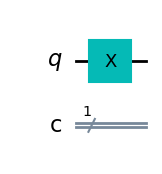

In [4]:
display(qubits[0].draw(output="mpl")) # Visualise the first qubit

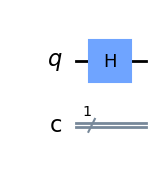

In [5]:
display(qubits[1].draw(output="mpl")) # Visualise the second qubit

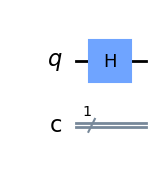

In [6]:
display(qubits[2].draw(output="mpl")) # Visualise the third qubit

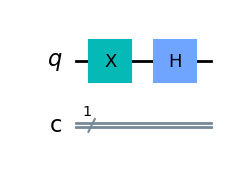

In [7]:
display(qubits[3].draw(output="mpl")) # Visualise the fourth qubit

### Step 2: Bob's measurement 

#### Bob randomly chooses to measure each qubit in either the X-basis or the Z-basis.

In [8]:
def bob_measure(qubits, bases): # Bob measures each qubit in randomly choosen X-basis or Z-basis.
    backend = BasicAer.get_backend('dm_simulator') # get the backend
    outcomes=""
    noise = {
    "thermal_factor": 0.,
    "decoherence_factor": .9,
    "depolarization_factor": 0.99,
    "bell_depolarization_factor": 0.99,
    "decay_factor": 0.99,
    "rotation_error": {'rx':[1., 0.], 'ry':[1., 0.], 'rz': [1., 0.]},
    "tsp_model_error": [1., 0.],
    "plot": False
} # noise parameters are added
    for i, qubit in enumerate(qubits):
        if bases[i] == 'X':
            qubit.h(0)
            
        qubit.measure(0, 0)
        result  = execute(qubit,backend,**noise).result()
        rho = result.results[0].data.densitymatrix # the density matrix
        probabilities = np.diag(rho)  # Probabilities for each state
        outcome = np.argmax(probabilities) # final outcome after operating on the qubit
        outcomes = outcomes + str(outcome) # adding it to the list of outcomes
    return outcomes


b_basis = generate_random_basis(bit_length)
print("Bob's random basis:", b_basis)

b_measurements = bob_measure(qubits, b_basis)
print("Bob's measurements:", b_measurements)

Bob's random basis: XZZZZXZZXXZXZXZZ
Bob's measurements: 1111111011001110


### Step 3: Basis Announcement and Key Sifting:

Alice and Bob publicly reveal the bases they used for each qubit over a classical channel. Then they start form the sifted key by keeping the bits for which their bases match.

#### Forming the Sifted Key

In [9]:
def sift_and_generate_key(alice_bits, bob_measurements, alice_bases, bob_bases):
    sifted_key = []
    for i in range(len(alice_bits)):
        if alice_bases[i] == bob_bases[i]: #they keep the qubits for which their bases match
            sifted_key.append(alice_bits[i])
    return ''.join(sifted_key)

sifted_key = sift_and_generate_key(a_bits, b_measurements, a_basis, b_basis)
print("Shared Key:", sifted_key)
print("Key Length:", len(sifted_key))

Shared Key: 1000110
Key Length: 7


### Step 4 : Privacy Amplification (Classical Post-processing)

#### Alice and Bob perform Privacy Amplification on the sifted key to obtain a secured secret key. 
Here I have used the SHA-256 (Secure Hash Algorithm 256-bit) which is a widely used cryptographic hash function that produces a 256-bit (32-byte) hash value. If we are using hexadecimal notation then digit codes represent 4 bits. In order to represent 256, we need 256/4 = 64 bits. So the final key length is always 64.

This step is not a direct part of the QKD protocol but its done to enhance the security of the sifted/shared key.

In [10]:
def privacy_amplification(shared_key): # encrypt the sifted key using SHA-256
    sha256_hash = hashlib.sha256(shared_key.encode()).hexdigest()
    return sha256_hash

final_key = privacy_amplification(sifted_key) #obtain the final encrypted key
print("Initial Shared Key:", sifted_key)
print("Final Shared Key:", final_key)
print("Final Key Length:", len(final_key))

Initial Shared Key: 1000110
Final Shared Key: ab7b20ad7f9295522f4e9256621025504e2f9040e49b176815e24b9ca4663b9e
Final Key Length: 64


### Step 5: Secure Communication

#### The final secret key can be used for encryption to enable secure communication between Alice and Bob.

The message is encrypted and decrypted using the using the AES (Advanced Encryption Standard) algorithm in CBC (Cipher Block Chaining) mode which is a widely used symmetric encryption algorithm.

This step is not a part of the QKD protocol but its done to demonstrate the use of the final key.

#### Importing the required libraries

In [11]:
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

####  Padding and Unpadding the Data

Padding is necessary for certain block cipher modes, including CBC, where the plaintext must be a multiple of the block size (16 bytes for AES). Here I have used PKCS7 padding.

In [12]:
def pad_data(data):
    # Pad the data to be a multiple of AES block size
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data) + padder.finalize()
    return padded_data

def unpad_data(padded_data):
    # Unpad the padded data after decryption
    unpadder = padding.PKCS7(algorithms.AES.block_size).unpadder()
    data = unpadder.update(padded_data) + unpadder.finalize()
    return data

#### The final secret key can be used for encryption to enable secure communication between Alice and Bob.

In [13]:
def encrypt_message(key, message): # encrypts the message using AES algorithm in CBC mode
    backend = default_backend()

    # Pad the message to be a multiple of AES block size
    padded_message = pad_data(message.encode())

    # Generate a random initialization vector (IV) of 16 bytes (128 bits)
    iv = os.urandom(16)

    # Create an AES cipher object in CBC mode with the shared key and IV
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)

    # Encrypt the padded message
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(padded_message) + encryptor.finalize()

    return iv + ciphertext

def decrypt_message(key, encrypted_message): # decrypts the message using AES algorithm in CBC mode
    backend = default_backend()

    # Extract the IV and ciphertext from the encrypted message
    iv = encrypted_message[:16]
    ciphertext = encrypted_message[16:]

    # Create an AES cipher object in CBC mode with the shared key and IV
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)

    # Decrypt the ciphertext
    decryptor = cipher.decryptor()
    decrypted_message = decryptor.update(ciphertext) + decryptor.finalize()

    # Unpad the decrypted message
    unpadded_message = unpad_data(decrypted_message)

    return unpadded_message.decode()

# Final shared secret key obtained from QKD
final_shared_key = bytes.fromhex(final_key)

# Alice encrypting a message using the final shared key
message_to_bob = "Hello Bob! I made pizza :-)"
encrypted_message = encrypt_message(final_shared_key, message_to_bob)
print("Encrypted Message:", encrypted_message)

# Bob decrypting the message using the final shared key
decrypted_message = decrypt_message(final_shared_key, encrypted_message)
print("Decrypted Message:", decrypted_message)


Encrypted Message: b'\xc3\x81\xc2\x89\xa3\x19\x1d\x9c_\xf0\x14Q\xdaF\xce\xd5\x9eO\xac\xec\xc4\xa8\xfd\xf5\x84\xa7K\xd8\xc4\xb6+\xc2\xb5/,\xf0|\xc2\xb29\xff\x1e,/?\xbe\x95b'
Decrypted Message: Hello Bob! I made pizza :-)
